In [168]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy import optimize, io
from scipy.sparse import spdiags
from scipy import sparse
import pickle
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 9)

In [169]:
# Importing datasets
Xtrain = np.genfromtxt('../HW5-6/Xtrain.csv', delimiter = ',')
Xtest = np.genfromtxt('../HW5-6/Xtest.csv', delimiter = ',')
ytrain = np.genfromtxt('../HW5-6/ytrain.csv', delimiter = ',')
ytest = np.genfromtxt('../HW5-6/ytest.csv', delimiter = ',')

# Log transforming inputs due to small magnitude on the tails
Xtrain = np.log(Xtrain + 0.1)
Xtest = np.log(Xtest + 0.1)

# Transforming training and testing labels from {1, 0} to {1, -1}
for i in range(len(ytrain)):
    if ytrain[i] == 0:
        ytrain[i] = -1
for i in range(len(ytest)):
    if ytest[i] == 0:
        ytest[i] = -1

In [170]:
# Loss Function
def L(w):
    tot = 0
    for i in range(Xtrain.shape[0]):
        tot += np.log(1 + np.exp(-ytrain[i]*w.T@Xtrain[i,:]))
    return tot
    
# Sigmoid Function
def sig(a):
    return 1/(1 + np.exp(-a))

# Gradient of Loss Function
def grad_L(w):
    mu = np.empty(Xtrain.shape[0])
    for i in range(Xtrain.shape[0]):
        t = sig(ytrain[i]*w.T@Xtrain[i,:])
        mu[i] = t
    return -Xtrain.T@(ytrain * (1 - mu))

In [171]:
def gradientDescentSolver(x_0, f, grad_f, lam, steps, linesearch_flag, rho, c, early_stop_flag):

    # Linesearch
    if linesearch_flag == 0:

        # Defining arrays and constants
        tol = 1e-4
        error = 10 # arbitrary to start
        x_n = np.array(x_0)
        F_arr = [f(x_0)]
        i = 0

        # Gradient descent loop
        while error > tol:
            i += 1
            x_prev = x_n

            # updating weight (position)
            x_n = x_n - lam*grad_f(x_n)

            # early stopping
            if (i == steps) & (early_stop_flag == 1):
                return x_n, F_arr, i

            # L-2 norm for error between points
            error = np.linalg.norm(x_n - x_prev)
            if i % 1000 == 0:
                print(f'Step: {i} | Error: {error}')
            F_arr.append(f(x_n))
            
        return x_n, F_arr, i

    # Gradient Descent
    else:
        t = 0.5 #optimal?
        p_k = -grad_f(x_0)
        while f(x_0 + t*p_k) > f(x_0) + c*t*grad_f(x_0)@p_k: #armijo condition
            t = rho*t

        return t

# Problem 1

## Stochastic Gradient Descent

In [172]:
# Initialize random starting point
w = np.random.rand(Xtrain.shape[1])

# Finding Lipschitz constant (L) from Xtrain and setting stepsize to 1/L
s_norm = np.linalg.norm(Xtrain,2)**2
lam = 1/s_norm

# Constants
steps = 3000
early_stop = 0

In [173]:
# Constants for line search
rho = 0.9
c = 0.5

# defining functions as parameters
func = L
grad = grad_L

# Pass to gradient solver (either stopping at n steps or going until tolerance)
step_flag = 0

w_trained, err, i = gradientDescentSolver(w, func, grad, lam, steps, step_flag, rho, c, early_stop)

Step: 1000 | Error: 0.0007726738725078277
Step: 2000 | Error: 0.0004890263823491814
Step: 3000 | Error: 0.0003353858800697258
Step: 4000 | Error: 0.0002459199956038992
Step: 5000 | Error: 0.00019245551759648462
Step: 6000 | Error: 0.00015831371962995113
Step: 7000 | Error: 0.00013479354964752893
Step: 8000 | Error: 0.00011761190609131882
Step: 9000 | Error: 0.00010450772830665407


## Nesterov Accelerated Gradient Descent

In [174]:
def NAG(x_0, f, grad_f, lam, steps, early_stop_flag):

    # Defining arrays and constants
    tol = 1e-4
    error = 10 # arbitrary to start

    # specific constant and initalization to NAG
    V_t = 0
    beta = 0.9

    # starting point and error for graphing loss
    x_n = np.array(x_0)
    F_arr = [f(x_0)]
    i = 0

    # Gradient descent loop
    while error > tol:
        i += 1
        x_prev = x_n
        
        # point based off history (looking ahead)
        x_look_ahead = x_n - lam*V_t

        # Use momentum but at the point ahead
        V_t = beta*V_t + (1 - beta)*grad_f(x_look_ahead)

        # Update current point
        x_n = x_n - lam*V_t

        # early stopping
        if (i == steps) & (early_stop_flag == 1):
            return x_n, F_arr, i

        # L-2 norm for error between points
        error = np.linalg.norm(x_n - x_prev)
        if i % 1000 == 0:
            print(f'Step: {i} | Error: {error}')
        F_arr.append(f(x_n))

    return x_n, F_arr, i

In [175]:
# defining gradient of loss as a parameter
grad = grad_L
func = L

# Pass to NAG solver (either stopping at n steps or going until tolerance)
w_trained_NAG, err_NAG, i_NAG = NAG(w, func, grad, lam, steps, early_stop)

Step: 1000 | Error: 0.0007791046051701219
Step: 2000 | Error: 0.0004929537263211276
Step: 3000 | Error: 0.0003375347185530996
Step: 4000 | Error: 0.00024694701521774765
Step: 5000 | Error: 0.00019294895351924655
Step: 6000 | Error: 0.00015857784295673875
Step: 7000 | Error: 0.00013494959896806185
Step: 8000 | Error: 0.00011771122525592833
Step: 9000 | Error: 0.00010457548875687446


## Nelder-Mead Simplex Method

In [176]:
# defining Loss Function as parameter
func = L

# Pass to Nelder-Mead simplex method (derivative-free)
Mead = optimize.minimize(func, w, method='nelder-mead', options={'return_all':True})

In [177]:
# Creating array from solutions from each iteration
Mead_arr = np.array(Mead.allvecs)
Mead_loss = [L(Mead_arr[i]) for i in range(Mead_arr.shape[0])]

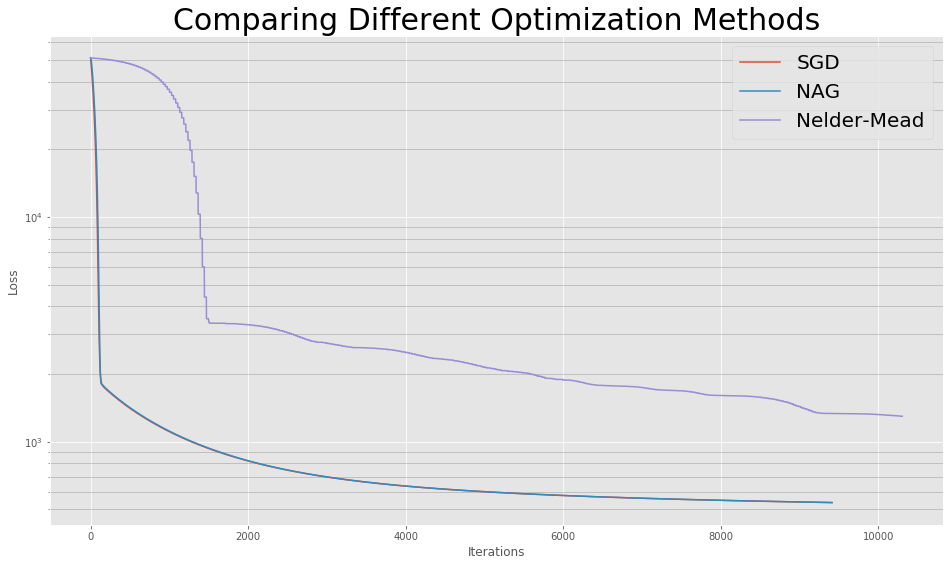

In [193]:
# Plotting Stochastic GD, Nesterov GD, and Nelder Mead
plt.semilogy(err, label='SGD')
plt.semilogy(err_NAG, label='NAG')
plt.semilogy(Mead_loss, label = 'Nelder-Mead')
plt.title('Comparing Different Optimization Methods', fontsize=30)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True, color='black', which='minor', alpha=0.2)
plt.legend(fontsize=20)

The graph above seems to show that SGD has a close enough curve to NAG due to Nelder-Mead being so different; however, note that we get different optimal values for the two and that this is not a bug.

# Problem 2

In [179]:
def prox(y, t, lam):
    
    # Prox function equivalent to argmin ...
    f = abs(y) - t*lam
    return np.sign(y)*np.maximum(f,0)

def prox_descent(x_0, prox_f, grad_f, lam, t, steps, early_stop_flag):

    # Defining arrays and constants
    tol = 1e-4
    error = 10 # arbitrary to start

    # starting point and error for graphing loss
    x_n = np.array(x_0)
    x_arr = [x_0]
    i = 0

    # Gradient descent loop
    while error > tol:
        i += 1
        x_prev = x_n
        
        # Update current point
        x_n = prox_f(x_n - t*grad_f(x_n), t, lam)

        # early stopping
        if (i == steps) & (early_stop_flag == 1):
            return x_n, x_arr, i

        # L-2 norm for error between points
        error = np.linalg.norm(x_n - x_prev)
        if i % 1000 == 0:
            print(f'Step: {i} | Error: {error}')
        x_arr.append(x_n)

    return x_n, x_arr, i

In [180]:
# Defining penalty constant and stepsize
t = lam
lam_pen = 5

# Passing functions as variables
prox_f = prox
grad_f = grad_L

prox_w, prox_err, prox_i = prox_descent(w, prox_f, grad_f, lam_pen, t, steps, early_stop)

Step: 1000 | Error: 0.0007811150940731733
Step: 2000 | Error: 0.0004968491201593191
Step: 3000 | Error: 0.00033358279082288154
Step: 4000 | Error: 0.00024469052340944506
Step: 5000 | Error: 0.0001867191077141173
Step: 6000 | Error: 0.0001538867682123282
Step: 7000 | Error: 0.00013155137605513523
Step: 8000 | Error: 0.00011615383486079
Step: 9000 | Error: 0.00010442058080406644


Text(0.5, 1.0, 'SGD Weights')

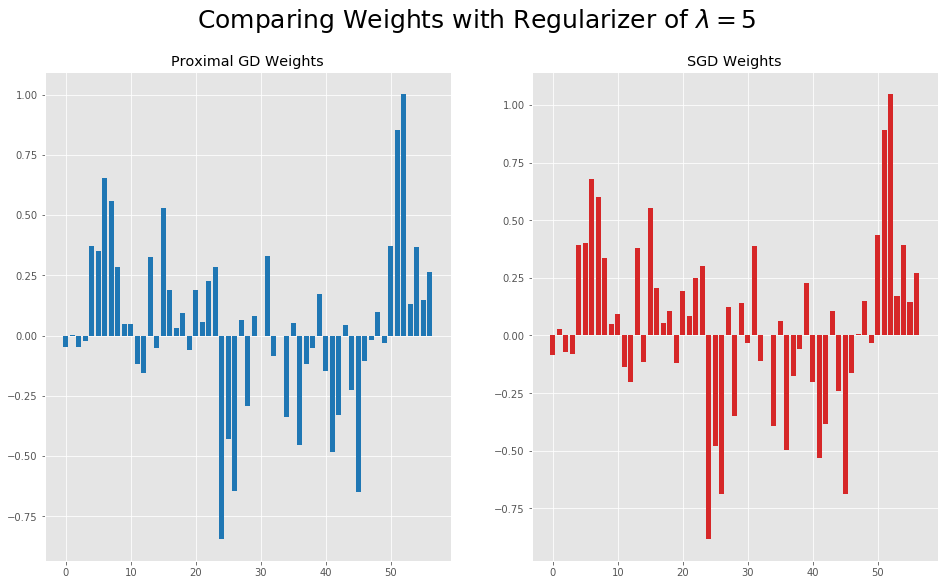

In [181]:
# Comparing Weights
# if we have no regularizer, then h(x) = 0 => SGD is used
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(r'Comparing Weights with Regularizer of $\lambda = 5$', fontsize=25)
ax1.bar(np.arange(prox_w.shape[0]), prox_w, color = 'tab:blue', label = 'Proximal GD Weights')
ax1.set_title('Proximal GD Weights')
ax2.bar(np.arange(prox_w.shape[0]), w_trained, color = 'tab:red', label = 'SGD Weights')
ax2.set_title('SGD Weights')

In [182]:
def acc(y_pred, y_true):
    m = y_pred - y_true
    m = np.sum(m == 0)
    return np.sum(m)/y_true.shape[0]
def convert2class(y_pred):

    # if simga(w^Tx_i) > 0.5, then classify it as spam (1)
    for i in range(len(y_pred)):
        if y_pred[i] > 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = -1

    return y_pred

# Passing through Sigmoid
# Prox
prox_pred = sig(Xtest @ prox_w)
prox_pred_train = sig(Xtrain @ prox_w)

# SGD
sgd_pred = sig(Xtest @ w_trained)
sgd_pred_train = sig(Xtrain @ w_trained)

# Converting to labels
# Prox
prox_pred = convert2class(prox_pred)
prox_pred_train = convert2class(prox_pred_train)

# SGD
sgd_pred = convert2class(sgd_pred)
sgd_pred_train = convert2class(sgd_pred_train)

# Compute training and testing accuracy
# Prox
prox_accuracy = acc(prox_pred, ytest)
prox_accuracy_train = acc(prox_pred_train, ytrain)

# SGD
sgd_accuracy = acc(sgd_pred, ytest)
sgd_accuracy_train = acc(sgd_pred_train, ytrain)

# Computer Classification error
# Prox
misclassifyrate_prox = 1 - prox_accuracy
misclassifyrate_train_prox = 1 - prox_accuracy_train

# SGD
misclassifyrate_sgd = 1 - sgd_accuracy
misclassifyrate_train_sgd = 1 - sgd_accuracy_train


In [183]:
print('Proximal GD(With Regularization):')
print(f'Accuracy: {prox_accuracy:0.4f} | Misclassification Rate: {misclassifyrate_prox:0.4f}')
print(f'Accuracy(training): {prox_accuracy_train:0.4f} | Misclassification Rate(training): {misclassifyrate_train_prox:0.4f}')

print('\nWithout Regualization:')
print(f'Accuracy: {sgd_accuracy:0.4f} | Misclassification Rate: {misclassifyrate_sgd:0.4f}')
print(f'Accuracy(training): {sgd_accuracy_train:0.4f} | Misclassification Rate(training): {misclassifyrate_train_sgd:0.4f}')

Proximal GD(With Regularization):
Accuracy: 0.9375 | Misclassification Rate: 0.0625
Accuracy(training): 0.9409 | Misclassification Rate(training): 0.0591

Without Regualization:
Accuracy: 0.9375 | Misclassification Rate: 0.0625
Accuracy(training): 0.9406 | Misclassification Rate(training): 0.0594


## Problem 3

In [184]:
image = plt.imread('SheppLogan_150x150.png')

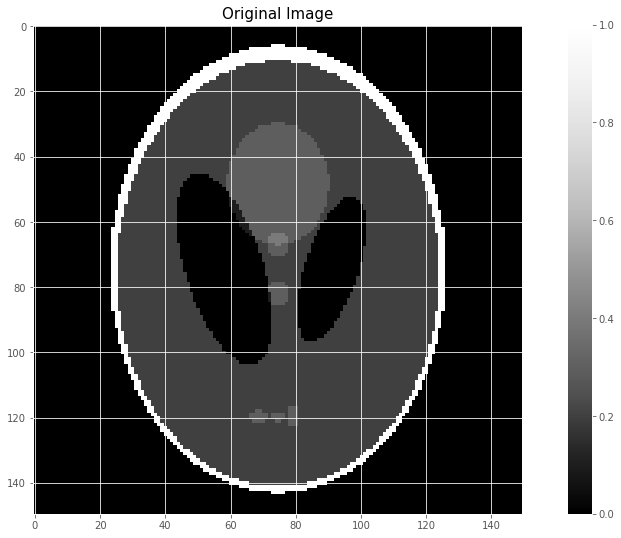

In [185]:
# Plotting original image
color_map = plt.cm.get_cmap('Greys')
plt.imshow(image, cmap=color_map.reversed())
plt.title('Original Image', fontsize = 15)
plt.colorbar()

In [186]:
def image_noise(image, noise_percent):
    # Setting up image for random noise
    shape = image.shape
    image_vector = np.array(image).flatten()
    n = len(image_vector)

    # Picking random indicies from image
    indices = np.random.randint(n, size=int(n*noise_percent))

    # Creating random noise from (0,1)
    noise = np.random.rand(int(n*noise_percent))

    # Applying noise to image
    image_vector[indices] += noise

    # Reshaping image to original dimensions
    noisy_image = image_vector.reshape(shape)
    
    return noisy_image

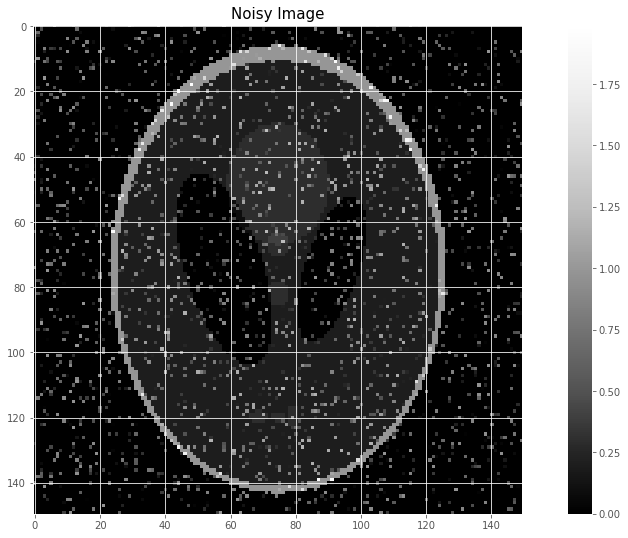

In [187]:
# Create Noise for the image
Y = image_noise(image, 0.1)

# Plotting noisy image
plt.imshow(Y, cmap=color_map.reversed())
plt.title('Noisy Image', fontsize=15)
plt.colorbar()

In [188]:
def D_matrix(n):
    D_arr = np.zeros((1, n))
    D = D_arr
    D[0,0] = -1
    D[0,1] = 1

    for i in range(1, n):
        D_next = np.roll(D[i - 1, :], 1)
        D = np.vstack((D, D_next))
        
    D[n - 1, 0] = 0
    return sparse.csr_matrix(D)

In [189]:
# Constants
n = Y.shape[0]
D = D_matrix(n)

# Operators
L_h_tilda = sparse.kron(D, np.eye(n))
L_v_tilda = sparse.kron(np.eye(n), D)

In [190]:
# defining our image copy
X = cvx.Variable((n,n))

# TV loss constraint
tao = 0.25
noise_Loss = TV(Y).value*tao

# Lambda functions for linear gradient operator
L_h = lambda Z: L_h_tilda @ cvx.vec(Z)
L_v = lambda Z: L_v_tilda @ cvx.vec(Z)

# defining the cost functions depending on the norm and dataset
TV = lambda Z: cvx.sum(cvx.norm(cvx.vstack([L_h(Z), L_v(Z)]), p=2, axis = 0))
constraints = [X <= 1, 
                X >= 0,
                TV(X) <= noise_Loss]

# Objective
obj1 = cvx.Minimize(0.5*cvx.norm(X - Y, "fro"))

# setting the problems in cvxpy
prob1 = cvx.Problem(obj1, constraints=constraints)

# solving the problems
prob1.solve(verbose=True)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.352e+04  +1e+05  2e-01  3e-02  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  +1.828e+03  -1.502e+03  +4e+04  3e-02  1e-03  7e-01  6e-01  0.7985  2e-01   3  3  3 |  0  0
 2  +2.344e+02  -3.119e+02  +8e+03  5e-03  2e-04  1e-01  1e-01  0.8158  6e-03   3  3  3 |  0  0
 3  +1.939e+01  -5.240e+01  +1e+03  6e-04  2e-05  7e-03  2e-02  0.8672  3e-02   3  4  4 |  0  0
 4  +1.827e+01  -1.587e+01  +6e+02  3e-04  9e-06  3e-03  9e-03  0.5472  8e-02   5  7  7 |  0  0
 5  +1.565e+01  -1.259e+01  +5e+02  2e-04  7e-06  2e-03  8e-03  0.4171  6e-01   5  4  5 |  0  0
 6  +1.344e+01  -4.578e+00  +3e+02  1e-04  4e-06  9e-04  5e-03  0.6291  4e-01   5  5  6 |  0  0
 7  +1.230e+01  -8.731e-01  +2e+02  1e-04  3e-06  5e-04  4e-03  0.5398  5e-01   5  6  6 |  0  0
 8  +1.210e+01  +1.453e-01  +2e+02  1e-04  3e-

11.085841434493313

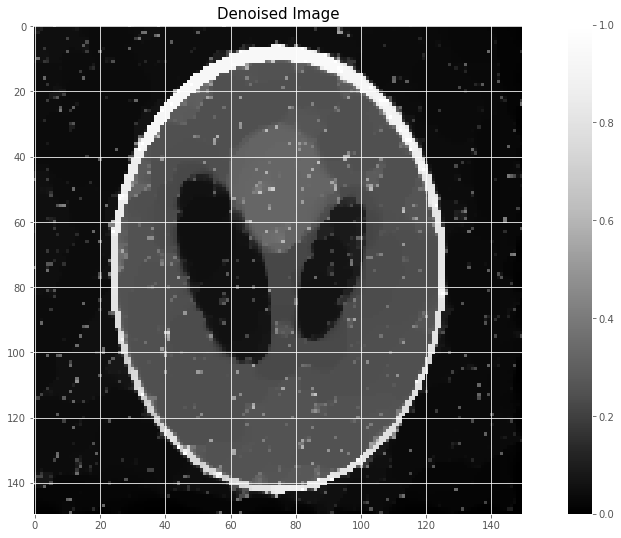

In [191]:
# Plotting Denoised Image
plt.imshow(X.value, cmap=color_map.reversed())
plt.title('Denoised Image', fontsize=15)
plt.colorbar()